In [4]:
# !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':'1-Hh3pdJlxhHWy42ZqXFDdjjBxe4vhoRg'})
downloaded.GetContentFile('train.csv') 

# Base Model


## Importing relevant libraries


In [1]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

## Exploring data


In [5]:
data = pd.read_csv('./nlp-getting-started/train.csv', encoding='utf-8')
# Only alter the training variable (#never alter the data variable itself)
pd.set_option('display.max_rows', None)
data

id                keyword  \
0         1                    NaN   
1         4                    NaN   
2         5                    NaN   
3         6                    NaN   
4         7                    NaN   
5         8                    NaN   
6        10                    NaN   
7        13                    NaN   
8        14                    NaN   
9        15                    NaN   
10       16                    NaN   
11       17                    NaN   
12       18                    NaN   
13       19                    NaN   
14       20                    NaN   
15       23                    NaN   
16       24                    NaN   
17       25                    NaN   
18       26                    NaN   
19       28                    NaN   
20       31                    NaN   
21       32                    NaN   
22       33                    NaN   
23       34                    NaN   
24       36                    NaN   
25       37                    NaN   
26       38                    NaN   
27       39                    NaN   
28       40                    NaN   
29       41                    NaN   
30       44                    NaN   
31       48                 ablaze   
32       49                 ablaze   
33       50                 ablaze   
34       52                 ablaze   
35       53                 ablaze   
36       54                 ablaze   
37       55                 ablaze   
38       56                 ablaze   
39       57                 ablaze   
40       59                 ablaze   
41       61                 ablaze   
42       62                 ablaze   
43       63                 ablaze   
44       64                 ablaze   
45       65                 ablaze   
46       66                 ablaze   
47       67                 ablaze   
48       68                 ablaze   
49       71                 ablaze   
50       73                 ablaze   
51       74                 ablaze   
52       76                 ablaze   
53       77                 ablaze   
54       78                 ablaze   
55       79                 ablaze   
56       80                 ablaze   
57       81                 ablaze   
58       82                 ablaze   
59       83                 ablaze   
60       85                 ablaze   
61       86                 ablaze   
62       89                 ablaze   
63       91                 ablaze   
64       92                 ablaze   
65       93                 ablaze   
66       95                 ablaze   
67       96               accident   
68       97               accident   
69       98               accident   
70      100               accident   
71      102               accident   
72      104               accident   
73      105               accident   
74      107               accident   
75      109               accident   
76      110               accident   
77      112               accident   
78      113               accident   
79      114               accident   
80      117               accident   
81      118               accident   
82      119               accident   
83      120               accident   
84      121               accident   
85      126               accident   
86      128               accident   
87      129               accident   
88      130               accident   
89      131               accident   
90      132               accident   
91      133               accident   
92      134               accident   
93      135               accident   
94      136               accident   
95      137               accident   
96      138               accident   
97      139               accident   
98      141               accident   
99      143               accident   
100     144               accident   
101     145               accident   
102     146             aftershock   
103     149             aftershock   
104     151        

### Analysis
- there are 7613 data points
- **99.198739%** of the data has **keywords**
- **66.73%** of the data has **location** points
- the top key word used to extract tweets is **fatalities**
- data is ordered in terms of keyword used to extact the tweet from twitter 
- therefore shuffle the data to mix it.
- some of the data contains the # symbol which causes an error when the data is exported onto a numpy array
- elements in the **text** column which does not have " " marks should not include **,** 
- data in the **location** column may also include **,** marks which will be read as a column delimeter by **np**

### Decisions 

- the most important columns are the text and target columns
- the text column contains information about the tweet
- the keyword column can be discarded because the keyword appears within the tweet itself.
- the location column can be discarded because only 66.73% have a location value associated with them. Droping 33% of the data is impractical
- it is however worth exploring whether location of tweet has an impact on the real or fake status of a tweet

- in some locations such as a city centre there cannot be a veld fire - so that is a consideration to be made


### Data cleaning

In [5]:
#### removing entries where location values are missing
data_after_null_removal = data.copy()
# data_after_null_removal = data_after_null_removal.dropna(subset=['location'])

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                                                                     text  \
0                                                            deeds reason earthquake may allah forgive us   
1                                                                   forest fire near la ronge sask canada   
2                residents asked shelter place notified officers evacuation shelter place orders expected   
3                                                  people receive wildfires evacuation orders california    
4                                                got sent photo ruby alaska smoke wildfires pours school    
...                                                                                                   ...   
7608                                               two giant cranes holding bridge collapse nearby homes    
7609              ariaahrary thetawniest control wild fires california even northern part state troubling   
7610                                                                                      volcano hawaii    
7611  police investigating ebike collided car little portugal ebike rider suffered serious nonlife thr...   
7612                                            latest homes razed northern california wildfire abc news    

      target  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
7608       1  
7609       1  
7610       1  
7611       1  
7612       1  

[7613 rows x 5 columns]

In [6]:
### train - test split
training, testing = train_test_split(data_without_tockenization, test_size=0.1, random_state=42, shuffle=True)

In [7]:
train = training.copy()
test = testing.copy()
# get the dependent and independent variables
train_x = train['text']
train_y = train['target']
test_x = test['text']
test_y = test['target']

## Preprocessing


In [6]:
train_x = np.array(train_x)
train_y = np.array(train_y)


# only work with the 3000 most popular words found in our dataset
max_words = 10000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Saving the dictionary
with open('./Dictionary_Models/dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

# padding tockenized text so that it is all the same length(longest word's length).
def convert_text_to_index_array(text):
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

#array of tweets as indeces(words replaced with indexes)
allWordIndices = np.asarray(allWordIndices)

# create one-hot matrices out of the indexed tweets
train_x = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')
# treat the labels as categories
train_y = keras.utils.to_categorical(train_y, 2)

## Model


In [20]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','Precision','Recall'])


history = model.fit(train_x, train_y,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

model_json = model.to_json()
with open('./NN_Models/base_model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('./NN_Models/base_model.h5')

print('saved model!')


Epoch 1/10
386/386 [==============================] - 18s 45ms/step - loss: 0.5376 - accuracy: 0.7273 - precision: 0.7273 - recall: 0.7273 - val_loss: 0.4491 - val_accuracy: 0.8090 - val_precision: 0.8090 - val_recall: 0.8090
Epoch 2/10
386/386 [==============================] - 15s 40ms/step - loss: 0.2578 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - val_loss: 0.5378 - val_accuracy: 0.7872 - val_precision: 0.7872 - val_recall: 0.7872
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


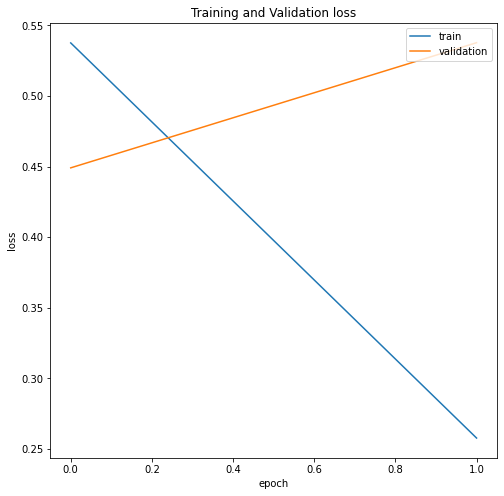

In [21]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Testing Model


In [23]:
# we're still going to use a Tokenizer here, but we don't need to fit it
tokenizer = Tokenizer(num_words=10000)
# for human-friendly printing
labels = ['fake', 'real']

# read in our saved dictionary
with open('./Dictionary_Models/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])

    return wordIndices

# read in your saved model structure
json_file = open('./NN_Models/base_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# and create a model from that
model = model_from_json(loaded_model_json)
# and weight your nodes with your saved values
model.load_weights('./NN_Models/base_model.h5')

predictions = []

for index_of_interest, text1 in enumerate(test_x):
    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    # predict which bucket your input belongs in

    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
        # predict which bucket your input belongs in
    pred = model.predict(input)

    predictions.append(np.argmax(pred))


In [24]:

predictions = np.array(predictions)
test_y = np.array(test_y)
confusion_matrix(test_y, predictions)

tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn +tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1_score = 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1_score], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index =['Negative', 'Positive']) 
df

Negative  Positive
Negative       361        65
Positive       110       226

In [25]:
results

Value
Accuracy   0.770341
Precision  0.776632
FPR        0.152582
Recall     0.672619
F1         0.720893

### Summary of Base model
- The highest achievable accuracy is 77%
- The best FPR is 0.09
- Model starts overfitting from the first epoch
- Validation loss never goes below ~0.45
- Attempts were made to vary the batch size. Large batch sizes yield worse performance. The best performance is at 32 or 16
- Increasing the number of layers also results in worse performance. Less layers produce better performance
- Drop out layers make little to no difference in performance
- Including tweets without the keyword seems to yield better performance
- Data cleaning produced a slightly less validation loss but not significant enough

# Self-trained Word2vec using Gensim

## using MLP

In [8]:
from gensim.models import Word2Vec, KeyedVectors

## Using LSTM

### Training own Word2vec model

In [9]:
data2 = data_without_tockenization.copy()

In [10]:

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data2.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

tockenized_data.head()

tweet_data = tockenized_data['text']
tweet_data[1]

tweet_data_array = []

for arr in tweet_data:
    tweet_data_array.append(arr)

In [11]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.tokenize import RegexpTokenizer

In [16]:
vector_size = 512
window_size = 10
# Create Word2Vec
word2vec_self_trained = Word2Vec(sentences=tweet_data_array,
                    size=vector_size, 
                    window=window_size, 
                    negative=20,
                    iter=50,
                    seed=1000,
                    workers=3)

In [17]:
word2vec_self_trained.save('./Embedding_Models/word2vecSelfTrained.model')

In [21]:
word2vec_self_trained = Word2Vec.load('./Embedding_Models/word2vecSelfTrained.txt')


In [33]:
X_vecs_self_trained = word2vec_self_trained.wv

X_vecs_self_trained

In [34]:
test_size = int(0.1*len(tweet_data))
train_size = len(tweet_data) - test_size

avg_length = 0.0
max_length = 0

for tweet in tweet_data:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tweet_data))))
print('Max tweet length: {}'.format(max_length))

max_tweet_length = 15

Average tweet length: 9.545514251937476
Max tweet length: 23


In [35]:
import keras.backend as K
### train - test split
training, testing = train_test_split(tockenized_data, test_size=0.1, random_state=42, shuffle=True)

training

x_train = training['text']
y_train = training['target']

x_test = testing['text']
y_test = testing['target']


X_train = np.zeros((len(training), max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((len(training), 2), dtype=np.int32)
X_test = np.zeros((len(testing), max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((len(testing), 2), dtype=np.int32)

train_y = np.array(y_train)

t=0
for index, tweet in enumerate(x_train):
    for word in tweet:
        if word not in X_vecs_self_trained:
            continue
        else:
            X_train[index, t, :] = X_vecs_self_trained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
                
            if train_y[index] == 1:
                 Y_train[index, :] = [1.0, 0.0] 
            else:
                Y_train[index, :] = [0.0, 1.0] 


In [36]:
test_y = np.array(y_test)

In [37]:
t=0
for index, tweet in enumerate(x_test):
    for word in tweet:
        if word not in X_vecs_self_trained:
            continue
        else:
            X_test[index, t, :] = X_vecs_self_trained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
#             print(test_y['target'] ,'\n')
            if test_y[index] == 1:
                 Y_test[index, :] = [1.0, 0.0] 
            else:
                Y_test[index, :] = [0.0, 1.0] 
#             Y_test[index, :] = [1.0, 0.0] if test_y[1] == 0 else [0.0, 1.0]

In [39]:
train_y = keras.utils.to_categorical(y_train, 2)


In [40]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()

model.add(LSTM(512))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])

In [42]:
model.fit(X_train, Y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

Epoch 1/10
386/386 [==============================] - 73s 190ms/step - loss: 0.5152 - accuracy: 0.7588 - precision: 0.7588 - recall: 0.7600 - val_loss: 0.5416 - val_accuracy: 0.7595 - val_precision: 0.7595 - val_recall: 0.7595
Epoch 2/10
386/386 [==============================] - 72s 187ms/step - loss: 0.4653 - accuracy: 0.7893 - precision: 0.7893 - recall: 0.7906 - val_loss: 0.5105 - val_accuracy: 0.7886 - val_precision: 0.7886 - val_recall: 0.7886
Epoch 3/10
386/386 [==============================] - 76s 198ms/step - loss: 0.4264 - accuracy: 0.8118 - precision: 0.8118 - recall: 0.8132 - val_loss: 0.5144 - val_accuracy: 0.7843 - val_precision: 0.7843 - val_recall: 0.7843
Epoch 00003: early stopping


In [43]:
X_train.shape

(6851, 15, 512)

In [44]:
model.evaluate(X_test,Y_test,batch_size=16)

w2vmodel_json = model.to_json()
with open('./NN_Models/w2vOwn_model.json', 'w') as json_file:
    json_file.write(w2vmodel_json)

model.save_weights('./NN_Models/w2vOwn_model.h5')

print('saved model!')

48/48 [==============================] - 7s 149ms/step - loss: 0.5383 - accuracy: 0.7690 - precision: 0.7690 - recall: 0.7711
saved model!


In [45]:
y_test_lstm_word2vec_self_trained = []

for ind, lab in Y_test:
    if Y_test[ind][0] == 0:
        y_test_lstm_word2vec_self_trained.append(0)
    else:
        y_test_lstm_word2vec_self_trained.append(1)

In [46]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)


tn_lstm_word2vec_self_trained, fp_lstm_word2vec_self_trained, fn_lstm_word2vec_self_trained, tp_lstm_word2vec_self_trained = confusion_matrix(y_test_lstm_word2vec_self_trained, y_pred).ravel()
precision_lstm_word2vec_self_trained = tp_lstm_word2vec_self_trained / (tp_lstm_word2vec_self_trained + fp_lstm_word2vec_self_trained)
accuracy_lstm_word2vec_self_trained = (tp_lstm_word2vec_self_trained + tn_lstm_word2vec_self_trained) / (tn_lstm_word2vec_self_trained + fp_lstm_word2vec_self_trained +fn_lstm_word2vec_self_trained +tp_lstm_word2vec_self_trained)
falsePositiveRate_lstm_word2vec_self_trained = fp_lstm_word2vec_self_trained / (fp_lstm_word2vec_self_trained + tn_lstm_word2vec_self_trained)
recall_lstm_word2vec_self_trained = tp_lstm_word2vec_self_trained/(tp_lstm_word2vec_self_trained+fn_lstm_word2vec_self_trained)
f1_score_lstm_word2vec_self_trained = 2 * ((recall_lstm_word2vec_self_trained*precision_lstm_word2vec_self_trained)/(recall_lstm_word2vec_self_trained+precision_lstm_word2vec_self_trained))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy_lstm_word2vec_self_trained, precision_lstm_word2vec_self_trained, falsePositiveRate_lstm_word2vec_self_trained, recall_lstm_word2vec_self_trained,f1_score_lstm_word2vec_self_trained], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results_lstm_word2vec_self_trained = pd.DataFrame(d) 
  

data = {'Negative':[tn_lstm_word2vec_self_trained, fn_lstm_word2vec_self_trained], 'Positive':[fp_lstm_word2vec_self_trained, tp_lstm_word2vec_self_trained]} 
  
# Creates pandas DataFrame. 
df_lstm_word2vec_self_trained = pd.DataFrame(data, index =['Negative', 'Positive']) 
df_lstm_word2vec_self_trained

Instructions for updating:
Please use Model.predict, which supports generators.


Negative  Positive
Negative       212       124
Positive        50       376

In [47]:
results_lstm_word2vec_self_trained

Value
Accuracy   0.771654
Precision  0.752000
FPR        0.369048
Recall     0.882629
F1         0.812095

## Using pre-trained word2vec model

In [7]:
import gensim.downloader as api

In [8]:
corpus = api.load('text8')

In [11]:
from gensim.models.word2vec import Word2Vec
pretrainedModel = Word2Vec(corpus)

In [12]:
word2vec_pretrained = pretrainedModel.save('./Embedding_Models/pretrainedModel.model')

In [13]:
# word2vec.save('pretrainedModel.model')
word2vec_pretrained = Word2Vec.load('./Embedding_Models/pretrainedModel.model')

In [14]:
X_vecs_pretrained = word2vec_pretrained.wv

X_vecs_pretrained

In [23]:
test_size = int(0.1*len(tweet_data))
train_size = len(tweet_data) - test_size

avg_length = 0.0
max_length = 0

for tweet in tweet_data:
    if len(tweet) > max_length:
        max_length = len(tweet)
    avg_length += float(len(tweet))
    
print('Average tweet length: {}'.format(avg_length / float(len(tweet_data))))
print('Max tweet length: {}'.format(max_length))

max_tweet_length = 15

Average tweet length: 9.545514251937476
Max tweet length: 23


In [29]:
import keras.backend as K
### train - test split
training, testing = train_test_split(tockenized_data, test_size=0.1, random_state=42, shuffle=True)
vector_size=100
training

x_train = training['text']
y_train = training['target']

x_test = testing['text']
y_test = testing['target']


X_train = np.zeros((len(training), max_tweet_length, vector_size), dtype=K.floatx())
Y_train = np.zeros((len(training), 2), dtype=np.int32)
X_test = np.zeros((len(testing), max_tweet_length, vector_size), dtype=K.floatx())
Y_test = np.zeros((len(testing), 2), dtype=np.int32)

train_y = np.array(y_train)

t=0
for index, tweet in enumerate(x_train):
    for word in tweet:
        if word not in X_vecs_pretrained:
            continue
        else:
            X_train[index, t, :] = X_vecs_pretrained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
                
            if train_y[index] == 1:
                 Y_train[index, :] = [1.0, 0.0] 
            else:
                Y_train[index, :] = [0.0, 1.0] 


In [30]:
test_y = np.array(y_test)
t=0
for index, tweet in enumerate(x_test):
    for word in tweet:
        if word not in X_vecs_pretrained:
            continue
        else:
            X_test[index, t, :] = X_vecs_pretrained[word]
            t+=1
            
            if t == max_tweet_length:
                t=0
#             print(test_y['target'] ,'\n')
            if test_y[index] == 1:
                 Y_test[index, :] = [1.0, 0.0] 
            else:
                Y_test[index, :] = [0.0, 1.0] 
#             Y_test[index, :] = [1.0, 0.0] if test_y[1] == 0 else [0.0, 1.0]

In [33]:
train_y = keras.utils.to_categorical(y_train, 2)


In [34]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()
model.add(LSTM(100))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

In [35]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','Precision','Recall'])

In [36]:
model.fit(X_train, Y_train,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

Epoch 1/10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
386/386 [==============================] - 13s 34ms/step - loss: 0.5162 - accuracy: 0.7594 - precision: 0.7594 - recall: 0.7622 - val_loss: 0.5352 - val_accuracy: 0.7624 - val_precision: 0.7624 - val_recall: 0.7624
Epoch 2/10
386/386 [==============================] - 12s 30ms/step - loss: 0.4415 - accuracy: 0.8018 - precision: 0.8018 - recall: 0.8047 - val_loss: 0.5180 - val_accuracy: 0.7580 - val_precision: 0.7580 - val_recall: 0.7580
Epoch 3/10
386/386 [==============================] - 12s 30ms/step - loss: 0.3946 - accuracy: 0.8277 - precision: 0.8277 - recall: 0.8307 - val_loss: 0.5162 - val_accuracy: 0.7653 - val_precision: 0.7653 - val_recall: 0.7653
Epoch 4/10
386/386 [==============================] - 12s 31ms/step - loss: 0.3323 - accuracy: 0.8610 - precision: 0.8608 - recall: 0.8639 - val_loss: 0.6082 - val_accuracy: 0.7653 - val_precision: 0.7653 - val_recall: 0.7653
Epoch 00004: ea

In [40]:
model.evaluate(X_test,Y_test,batch_size=16)
w2vmodelpt_json = model.to_json()
with open('./NN_Models/w2vPreTmodel.json', 'w') as json_file:
    json_file.write(w2vmodelpt_json)

model.save_weights('./NN_Models/w2vPreTmodel.h5')

print('saved model!')

48/48 [==============================] - 0s 9ms/step - loss: 0.6478 - accuracy: 0.7625 - precision: 0.7625 - recall: 0.7635
saved model!


In [41]:
y_test_lstm_word2vec_pretrained = []

for ind, lab in Y_test:
    if Y_test[ind][0] == 0:
        y_test_lstm_word2vec_pretrained.append(0)
    else:
        y_test_lstm_word2vec_pretrained.append(1)

In [42]:
predictions = []
Y_pred = model.predict_generator(X_test)
y_pred = np.argmax(Y_pred, axis=1)


tn_lstm_word2vec_pretrained, fp_lstm_word2vec_pretrained, fn_lstm_word2vec_pretrained, tp_lstm_word2vec_pretrained = confusion_matrix(y_test_lstm_word2vec_pretrained, y_pred).ravel()
precision_lstm_word2vec_pretrained = tp_lstm_word2vec_pretrained / (tp_lstm_word2vec_pretrained + fp_lstm_word2vec_pretrained)
accuracy_lstm_word2vec_pretrained = (tp_lstm_word2vec_pretrained + tn_lstm_word2vec_pretrained) / (tn_lstm_word2vec_pretrained + fp_lstm_word2vec_pretrained +fn_lstm_word2vec_pretrained +tp_lstm_word2vec_pretrained)
falsePositiveRate_lstm_word2vec_pretrained = fp_lstm_word2vec_pretrained / (fp_lstm_word2vec_pretrained + tn_lstm_word2vec_pretrained)
recall_lstm_word2vec_pretrained = tp_lstm_word2vec_pretrained/(tp_lstm_word2vec_pretrained+fn_lstm_word2vec_pretrained)
f1_score_lstm_word2vec_pretrained = 2 * ((recall_lstm_word2vec_pretrained*precision_lstm_word2vec_pretrained)/(recall_lstm_word2vec_pretrained+precision_lstm_word2vec_pretrained))

# Intialise data to Dicts of series. 
d_lstm_word2vec_pretrained = {'Value' : pd.Series([accuracy_lstm_word2vec_pretrained, precision_lstm_word2vec_pretrained, falsePositiveRate_lstm_word2vec_pretrained, recall_lstm_word2vec_pretrained,f1_score_lstm_word2vec_pretrained], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results_lstm_word2vec_pretrained = pd.DataFrame(d_lstm_word2vec_pretrained) 
  

data_lstm_word2vec_pretrained = {'Negative':[tn_lstm_word2vec_pretrained, fn_lstm_word2vec_pretrained], 'Positive':[fp_lstm_word2vec_pretrained, tp_lstm_word2vec_pretrained]} 
  
# Creates pandas DataFrame. 
df_lstm_word2vec_pretrained = pd.DataFrame(data_lstm_word2vec_pretrained, index =['Negative', 'Positive']) 
df_lstm_word2vec_pretrained

Instructions for updating:
Please use Model.predict, which supports generators.


Negative  Positive
Negative       218       118
Positive        62       364

In [43]:
results_lstm_word2vec_pretrained

Value
Accuracy   0.763780
Precision  0.755187
FPR        0.351190
Recall     0.854460
F1         0.801762

## Summary for pretrained embeddings


- The results for models trained on own dataset are similar to those for training on own dataset.
- The pretrained embedding models perform much better than the models that use the keras embedding layer.
- The reason for this is that pretrained models reach a low loss function faster than the models that are trained using the keras embedding layer.
- By the time the early stopping kicks in, the pretrained models already have a good performance.
- The keras embedding layer embeddings only train during training the model hence they also affect how quickly the loss function decays.
- Precision, Recall and F1 score are the only metrics which improve.
